In [2]:
def compute_receptive_field(depth, kernel_size, downsample_factor):
    fov = 1
    downsample_factor_prod = 1
    # encoder
    for layer in range(depth - 1):
        # two convolutions, each adds (kernel size - 1 ) * current downsampling level
        fov = fov + 2 * (kernel_size - 1) * downsample_factor_prod
        # downsampling multiplies by downsample factor
        fov = fov * downsample_factor
        downsample_factor_prod *= downsample_factor
    # bottom layer just two convs
    fov = fov + 2 * (kernel_size - 1) * downsample_factor_prod

    # decoder
    for layer in range(0, depth - 1)[::-1]:
        # upsample
        downsample_factor_prod /= downsample_factor
        # two convolutions, each adds (kernel size - 1) * current downsampling level
        fov = fov + 2 * (kernel_size - 1) * downsample_factor_prod

    return fov

In [3]:
depth = 4
kernel_size = 3
downsample_factor = 2
compute_receptive_field(depth, kernel_size, downsample_factor)

164.0

/tmp/ipykernel_362116/641031235.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(model_path), strict=False)


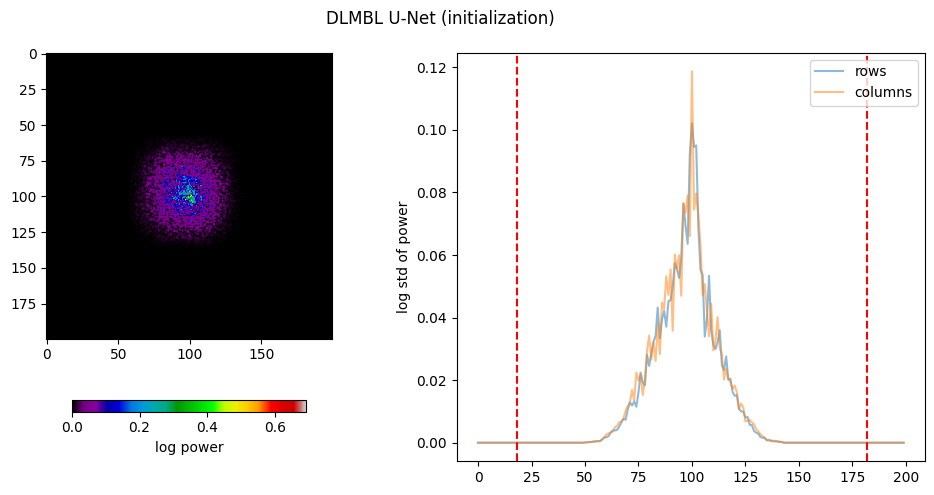

In [8]:
# %%
"""
Script to visualize the effective receptive field.
Original paper:
https://doi.org/10.48550/arXiv.1701.04128 (Luo et al., 2017).
"""

# %%
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import torch

from dl_mbl_gut.model import UNet
#from viscy.light.engine import VSUNet

device = "cpu"


# %%
def plot_response(model: torch.nn.Module, title: str, ndim: Literal[2, 3] = 3) -> None:
    impulse_pattern = torch.zeros(1, 1, 200, 200, device=device)
    impulse_pattern[0, 0, 100, 100] = torch.finfo(torch.float32).eps
    if ndim == 3:
        impulse_pattern = impulse_pattern.unsqueeze(0)
    impulse = impulse_pattern.clone().requires_grad_(True)

    model.zero_grad()
    input_image = torch.zeros_like(impulse, requires_grad=True)
    fake_response = model(input_image)
    fake_loss = (fake_response * impulse_pattern.clone()).sum()
    fake_loss.backward()
    response_backwards = input_image.grad.detach().cpu().numpy()
    if ndim == 3:
        response_backwards = response_backwards.squeeze(0)
    scaled_response = response_backwards[0, 0] / response_backwards.max()

    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    spectrum = np.log1p(np.abs(scaled_response))
    im = ax[0].imshow(spectrum, cmap="nipy_spectral")
    _ = plt.colorbar(im, label="log power", shrink=0.5, location="bottom")
    ax[1].plot(np.log1p(scaled_response.std(axis=(0))), label="rows", alpha=0.5)
    ax[1].plot(np.log1p(scaled_response.std(axis=(1))), label="columns", alpha=0.5)
    ax[1].axvline(x=100-(164/2), color='red', linestyle='--')
    ax[1].axvline(x=100+(164/2), color='red', linestyle='--')
    ax[1].legend()
    ax[1].set_ylabel("log std of power")
    f.suptitle(title)
    f.tight_layout()


# %%
#unet = UNet(depth=4, in_channels=1).to(device)

unet = UNet(
    depth=4,
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    num_fmaps=64,
    fmap_inc_factor=2,
    padding="same",
    final_activation=torch.nn.Sigmoid(),
    ndim=2,
).to(device)

from pathlib import Path
model_path = Path(
        "/mnt/efs/dlmbl/G-bs/models/09-01-2d-large-fov-same_model_epoch_1.pth"
    )
unet.load_state_dict(torch.load(model_path), strict=False)
unet.to("cpu")

plot_response(unet, "DLMBL U-Net (initialization)", ndim=2)


/tmp/ipykernel_362116/65387754.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(model_path), strict=False)


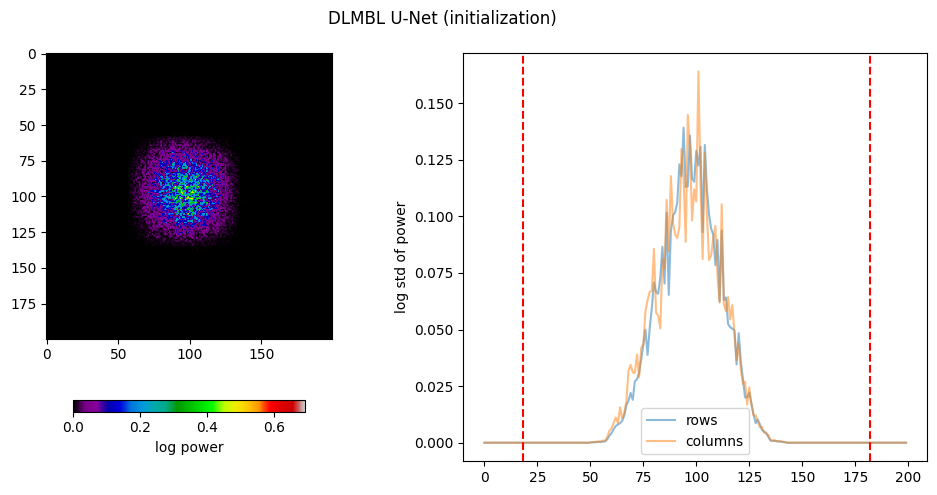

In [11]:
model_path = Path(
        "/mnt/efs/dlmbl/G-bs/models/09-01-2d-large-fov-same_model_epoch_13.pth"
    )
unet.load_state_dict(torch.load(model_path), strict=False)
unet.to("cpu")

plot_response(unet, "DLMBL U-Net (initialization)", ndim=2)
